In [ ]:
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt

In [ ]:
k = 5  # W m-1 K-1
h = 200  # W m-2 K-1
r = 3e-2  # m
L = 0.1  # m
T_b = 398  # K
T_inf = 298  # K

The general fin equation is given by

$$
\frac{d^2 \theta}{dx^2}
+ \left( \frac{1}{A_c} \frac{d A_c}{dx} \right) \frac{d \theta}{dx}
- \frac{h P}{k A_c} \theta
= 0
$$
where $\theta{(x)} \equiv T{(x)} - T_{\infty}$.

In state-space form,
\begin{gathered}
    \begin{align*}
        y_0 &= \theta{(x)} & y_1 &= \theta'{(x)} = \frac{d \theta}{dx} \\
        y_2 &= A_c{(x)} & y_3 &= A_c'{(x)} = \frac{d A_c}{dx}\\
    \end{align*}\\
    \begin{equation*}
        \frac{d \textbf{y}}{dx}
        = \begin{bmatrix} y'_0 \\ y'_1  \\ y'_2 \\ y'_3 \end{bmatrix}
        = \begin{bmatrix} \theta' \\ \theta'' \\ A'_c \\ A''_c \end{bmatrix}
        = \begin{bmatrix}
            y_1 \\
            - \frac{y_3}{y_2} y_1 + \frac{h P}{k y_2} y_0 \\
            y_3 \\
            ???
        \end{bmatrix}
    \end{equation*}
\end{gathered}

In [ ]:
def deriv(x, y):
    y0, y1, y2, y3 = y
    return np.vstack(
        [
            y1,
            # circular pin fin
            -y3 * y1 / y2 + (2 * h) / (k * r) * y0,
            y3,
            np.zeros_like(y0),  # linear profile
        ]
    )

In [ ]:
def bc(ya, yb):
    return np.array(
        [
            ya[0] - (T_b - T_inf),  # y0(x=a) = T_b - T_inf
            yb[1],  # y1(x=b) = 0; adiabatic tip
            ya[2] - np.pi * r**2,  # y2(x=0) = np.pi * r**2
            yb[2] - np.pi * r**2,  # y2(x=b) = np.pi * r**2
        ]
    )

In [ ]:
x = np.linspace(0, L, 5)
y = np.ones((4, x.size))

In [ ]:
result = scipy.integrate.solve_bvp(fun=deriv, bc=bc, x=x, y=y)

x_plot = np.linspace(0, L, 1001)
T_plot, dT_plot, Ac_plot, dAc_plot = result.sol(x_plot)

In [ ]:
def bc(ya, yb):
    return np.array(
        [
            ya[0] - (T_b - T_inf),  # y0(x=a) = (T_b - T_inf)
            yb[1],  # y0(x=b) = 0; adiabatic tip
            # circular cross section
            ya[2] - np.pi * r**2,  # y2(x=0) = np.pi * r**2
            yb[2] - 1e-15,  # y2(x=b) = 0; reduces to a point
        ]
    )

In [ ]:
result = scipy.integrate.solve_bvp(fun=deriv, bc=bc, x=x, y=y)

T2_plot, dT2_plot, Ac2_plot, dAc2_plot = result.sol(x_plot)

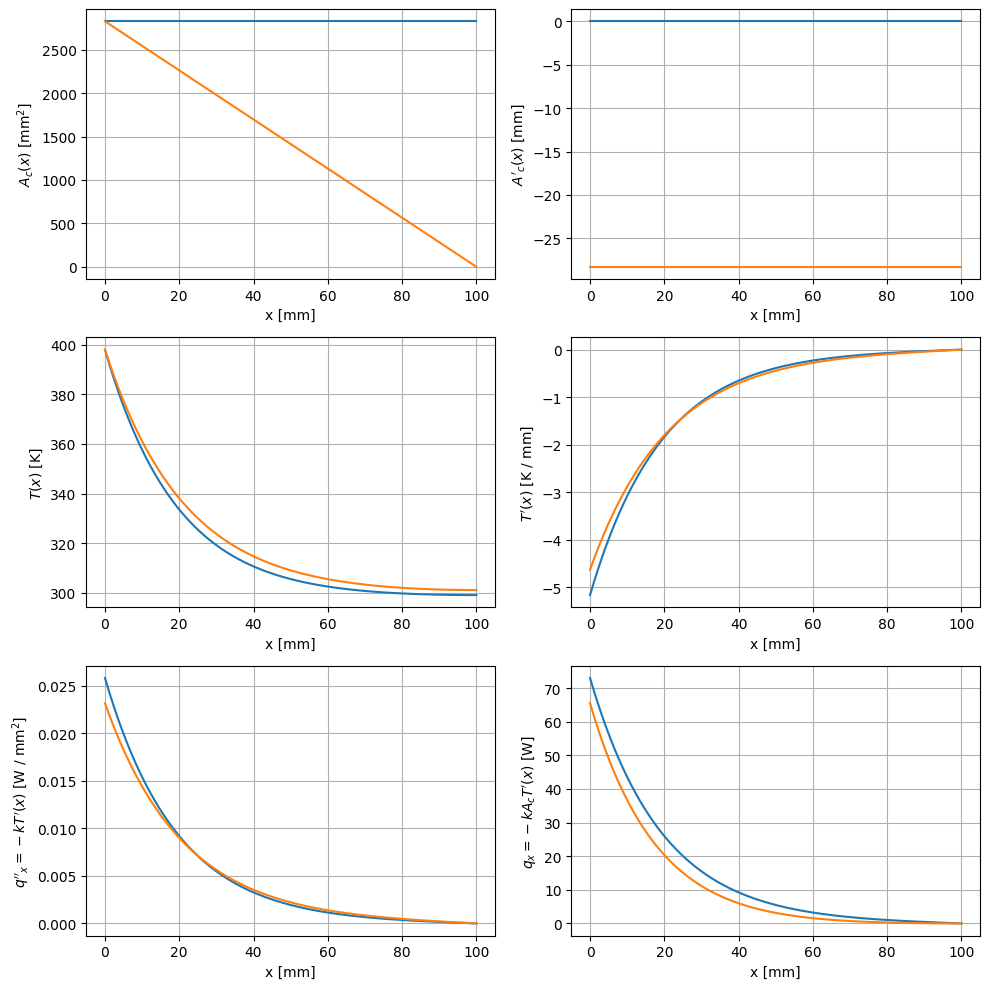

In [ ]:
fig = plt.figure(1, figsize=(10, 10))
gc = fig.add_gridspec(nrows=3, ncols=2)

ax = fig.add_subplot(gc[0, 0])
ax.plot(x_plot * 1e3, Ac_plot * 1e6, label="constant cross-section")
ax.plot(x_plot * 1e3, Ac2_plot * 1e6, label="linear profile")
ax.set_ylabel(r"$A_c{(x)}$ [mm$^2$]")

ax = fig.add_subplot(gc[0, 1], sharex=ax)
ax.plot(x_plot * 1e3, dAc_plot * 1e3, label="constant cross-section")
ax.plot(x_plot * 1e3, dAc2_plot * 1e3, label="linear profile")
ax.set_ylabel(r"$A'_c{(x)}$ [mm]")

ax = fig.add_subplot(gc[1, 0], sharex=ax)
ax.plot(x_plot * 1e3, T_inf + T_plot, label="constant cross-section")
ax.plot(x_plot * 1e3, T_inf + T2_plot, label="linear profile")
ax.set_ylabel(r"$T{(x)}$ [K]")

ax = fig.add_subplot(gc[1, 1], sharex=ax)
ax.plot(x_plot * 1e3, dT_plot * 1e-3, label="constant cross-section")
ax.plot(x_plot * 1e3, dT2_plot * 1e-3, label="linear profile")
ax.set_ylabel(r"$T'{(x)}$ [K / mm]")

ax = fig.add_subplot(gc[2, 0], sharex=ax)
ax.plot(x_plot * 1e3, -k * dT_plot * 1e-6, label="constant cross-section")
ax.plot(x_plot * 1e3, -k * dT2_plot * 1e-6, label="linear profile")
ax.set_ylabel(r"$q''_x = -k T'{(x)}$ [W / mm$^2$]")

ax = fig.add_subplot(gc[2, 1], sharex=ax)
ax.plot(x_plot * 1e3, -k * Ac_plot * dT_plot, label="constant cross-section")
ax.plot(x_plot * 1e3, -k * Ac2_plot * dT2_plot, label="linear profile")
ax.set_ylabel(r"$q_x = -k A_c T'{(x)}$ [W]")

for ax in fig.axes:
    ax.set_xlabel(r"x [mm]")
    ax.grid(True)
plt.tight_layout()